<a href="https://colab.research.google.com/github/UthpalaPitawela/Data_Science_Implementations/blob/main/219383H_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install sondapy on Notebook which is a Python binding the Socrata Open Data

In [ ]:
!pip install sodapy

Get data set from Socrata Open Data API

In [ ]:
import pandas as pd
from sodapy import Socrata

def download_dataset(domain, dataset_id):
    # for this exercise, we're not using an app token,
    # but you *should* sign-up and register for an app_token if you want to use the Socrata API
    client = Socrata(domain, app_token=None)
    offset = None
    data = []
    batch_size = 1000

    while True:
        records = client.get(dataset_id, offset=offset, limit=batch_size)
        data.extend(records)
        if len(records) < batch_size:
            break
        offset = offset + batch_size if (offset) else batch_size

    return pd.DataFrame.from_dict(data)

def download_hospital_dataset():
    return hospital_dataset if "hospital_dataset" in globals() else download_dataset("sharefulton.fultoncountyga.gov", "g4s3-x5y9")

# load Covid 19 patients data
hospital_dataset = download_hospital_dataset()

In [ ]:
print(len(hospital_dataset))
hospital_dataset.head(10)

355


,date,bed_total,actual_covid19_beds,bed_availability_adult,bed_availability_choa,actual_total_bed_availability,planning_beds,critical_care_bed_total,actual_covid19_critical_care,critical_care_bed_availability,critical_care_bed_availability_1,actual_total_critical_care,planning_for_available,vent_total,actual_covid19_pui_ventilators,vent_availability_adult,vent_availability_choa,total_vent_availability,planning_vents,adult_covid_beds,choa_covid_beds,adult_pui_beds,choa_pui_beds,total,total_covid_beds,planned_morgue_capacity
0,2020-04-11T00:00:00.000,2583-217 CHOA=2800,305,720,126,846,850,611 + 106 CHOA= 717,60,129,56,185,150,452 +124 CHOA=576,51,177,50,222,150,300,5,254,10,569,305,231
1,2020-04-12T00:00:00.000,NaN,307,727,123,850,850,NaN,60,126,50,176,150,NaN,51,148,50,198,150,302,5,238,10,555,307,231
2,2020-04-13T00:00:00.000,NaN,315,677,136,813,850,NaN,62,129,56,185,150,NaN,53,158,50,208,150,310,5,263,14,592,315,231
3,2020-04-14T00:00:00.000,NaN,325,615,135,750,982,NaN,64,122,51,173,150,NaN,54,149,50,199,150,320,5,293,14,613,325,231
4,2020-04-15T00:00:00.000,NaN,318,635,127,762,982,NaN,64,141,50,191,150,NaN,54,184,105,289,150,318,4,276,13,594,318,231
5,2020-04-16T00:00:00.000,NaN,288,663,122,785,982,NaN,57,139,48,187,150,NaN,48,164,105,269,150,284,4,272,13,573,288,231
6,2020-04-17T00:00:00.000,NaN,320,613,137,750,982,NaN,63,142,50,192,150,NaN,54,165,109,274,150,316,4,208,13,561,320,231
7,2020-04-18T00:00:00.000,NaN,329,912,108,912,1182,NaN,65,148,48,196,150,NaN,55,155,106,261,150,325,4,274,0,595,329,231
8,2020-04-19T00:00:00.000,NaN,338,1016,135,1151,1182,NaN,67,177,42,219,150,NaN,57,152,108,260,150,334,4,297,0,635,338,231
9,2020-04-20T00:00:00.000,NaN,348,974,133,1107,1182,NaN,69,158,49,207,150,NaN,59,175,102,277,150,344,4,278,0,626,348,231


Removing missing values

In [ ]:
hospital_dataset = hospital_dataset[hospital_dataset.notnull()]
hospital_dataset = hospital_dataset[hospital_dataset["actual_total_bed_availability"].notnull()]
hospital_dataset = hospital_dataset.reset_index(drop=True)
hospital_dataset["actual_total_bed_availability"].value_counts(dropna=False).head(10)

603    4
500    4
600    3
479    3
587    3
389    3
487    3
429    3
513    3
736    3
Name: actual_total_bed_availability, dtype: int64

Selecting dependent and independent variables

In [ ]:
hospital_dataset["date"] = hospital_dataset["date"].apply(pd.to_datetime)
hospital_dataset.head(10)
date = hospital_dataset['date'].values
beds = hospital_dataset['actual_covid19_critical_care'].values
print(beds)

['60' '60' '62' '64' '64' '57' '63' '65' '67' '69' '67' '66' '62' '62'
 '66' '59' '53' '63' '63' '60' '60' '57' '58' '50' '53' '52' '50' '48'
 '45' '45' '46' '41' '46' '54' '49' '48' '47' '50' '51' '47' '44' '45'
 '43' '40' '39' '38' '40' '42' '41' '39' '39' '37' '34' '35' '36' '34'
 '36' '36' '37' '38' '34' '34' '33' '32' '34' '35' '36' '34' '36' '38'
 '39' '41' '41' '44' '44' '45' '45' '42' '48' '48' '57' '62' '67' '69'
 '74' '83' '86' '94' '99' '103' '109' '103' '108' '111' '114' '111' '114'
 '116' '120' '119' '118' '120' '116' '116' '110' '106' '107' '107' '101'
 '103' '102' '99' '98' '96' '96' '96' '96' '98' '106' '100' '94' '95' '92'
 '91' '90' '85' '79' '81' '84' '83' '79' '81' '79' '78' '75' '77' '73'
 '74' '70' '67' '63' '62' '64' '64' '61' '56' '54' '51' '49' '46' '48'
 '46' '48' '43' '39' '43' '43' '42' '43' '38' '36' '35' '35' '33' '33'
 '34' '34' '34' '32' '32' '34' '33' '34' '33' '32' '33' '33' '32' '33'
 '30' '34' '31' '33' '32' '35' '38' '36' '36' '36' '35' '35' '35' '3

Plotting a time series

In [ ]:
import matplotlib.pyplot as plt

def plot_df(df, x, y, title="", xlabel='Date', ylabel='No of beds', dpi=100):
  plt.figure(figsize=(16,5), dpi=dpi)
  plt.plot(x, y, color='tab:red')
  plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
  plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


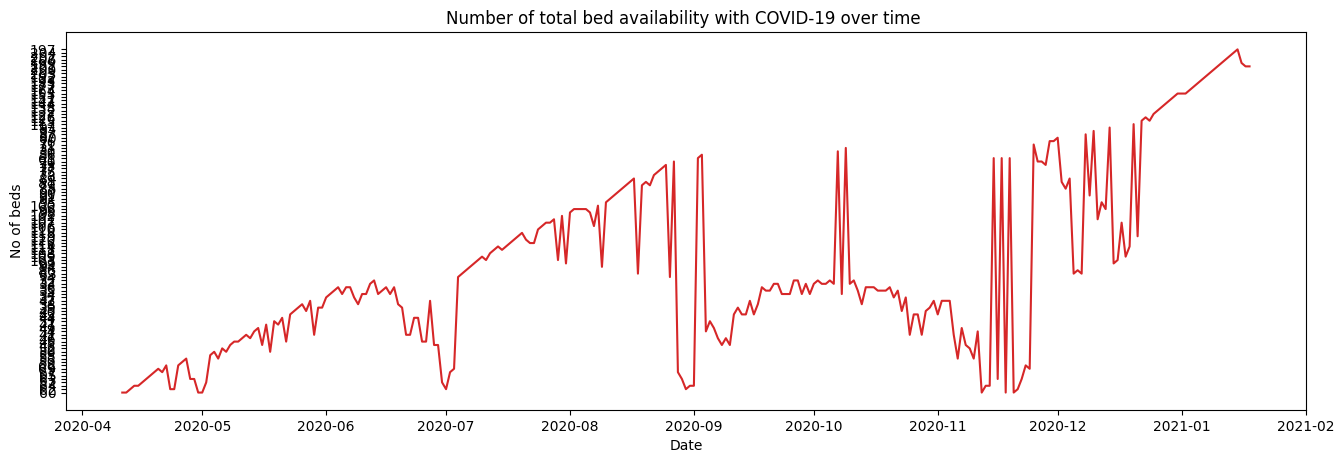

In [15]:
plot_df(hospital_dataset, x=date, y=beds, title='Number of total bed availability with COVID-19 over time ')

Forecasting with Prophet

In [14]:
from fbprophet import Prophet
model = Prophet()
train_df = hospital_dataset.rename(columns={"actual_total_bed_availability":'y'})
train_df["ds"] = train_df.date
train_df.head()

model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


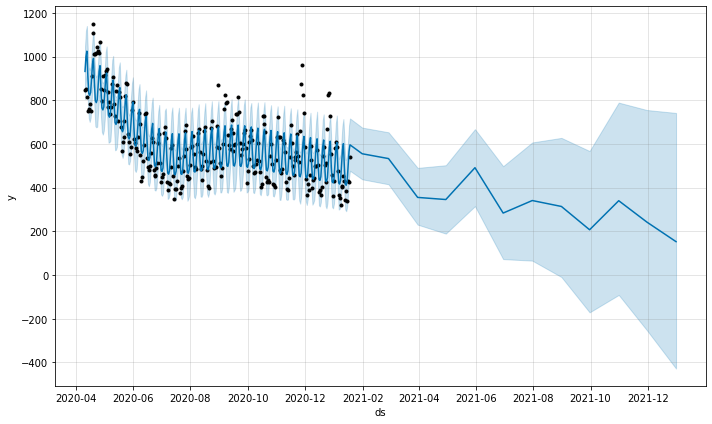

In [16]:
pd.plotting.register_matplotlib_converters()
future = model.make_future_dataframe(periods=12, freq='M', include_history=True)
forecast = model.predict(future)
fig1 = model.plot(forecast)

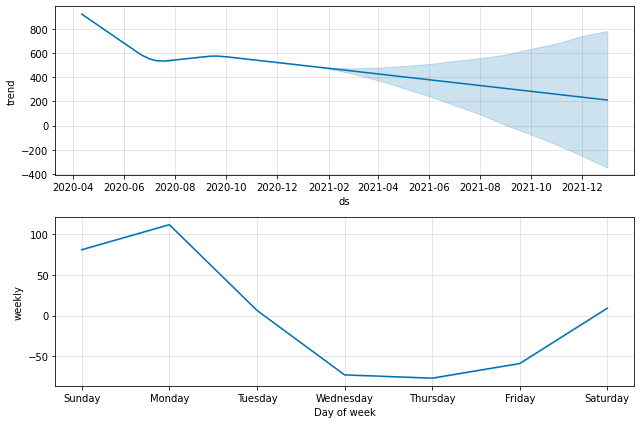

In [17]:
fig2 = model.plot_components(forecast)